In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as ss
import pandas as pd
import glob
import os

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

In [3]:
fs = 2500
half_window_size = int(0.1*fs/2.)    

In [4]:
X = list()
y = list()
file_list = glob.glob(os.path.join('data', 'processed', '*'))

for f in file_list:
    df = pd.read_pickle(f)
    
    X_raw = np.array(df['LFP'])
    cand_loc = np.array(df['ripple_cand'])
    true_loc = np.array(df['ripple_true'])
    cand_index = np.argwhere(cand_loc==1)
    true_index = np.argwhere(true_loc==1)
    print(cand_index.shape, true_index.shape)
    
    for counter, index in enumerate(cand_index):
        X.append(X_raw[int(index-half_window_size):int(index+half_window_size)])
        if index in true_index:
            y.append(np.array([0,1]))
        else:
            y.append(np.array([1,0]))
            
X = np.array(X)
y = np.array(y)

X = np.expand_dims(X, axis=-1)
np.sum(y, axis=0)[1]/y.shape[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(418, 1) (113, 1)
(269, 1) (121, 1)
(187, 1) (111, 1)
(214, 1) (130, 1)


In [5]:
X.shape

(1088, 250, 1)

In [6]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.utils.vis_utils import plot_model
from keras.layers.normalization import BatchNormalization

from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

def decode(value, threshold=0.992):
    mask = value[:,1]>threshold
    y_pred_int = np.array(mask, dtype=int)
    return y_pred_int

Using TensorFlow backend.


In [7]:
def generate_model_CNN(input_shape, padding='same'):
    keras.backend.clear_session()

    input_layer = keras.layers.Input(shape=input_shape)
    x = keras.layers.GaussianNoise(0.1)(input_layer)

    x = keras.layers.Conv1D(filters=20,kernel_size=7,padding=padding,
                                activation='relu')(x)
    x = keras.layers.AveragePooling1D(pool_size=2)(x)
    x = keras.layers.BatchNormalization()(x)
#     x = keras.layers.GaussianNoise(1.5)(x)


    x = keras.layers.Conv1D(filters=20,kernel_size=7,padding=padding,
                                activation='relu')(x)
    x = keras.layers.AveragePooling1D(pool_size=2)(x)
    x = keras.layers.BatchNormalization()(x)
#     x = keras.layers.GaussianNoise(1.5)(x)

#     conv3 = keras.layers.Conv1D(filters=10,kernel_size=7,padding=padding,
#                                 activation='relu')(conv2)
#     conv3 = keras.layers.AveragePooling1D(pool_size=2)(conv3)
#     conv3 = keras.layers.BatchNormalization()(conv3)
#     conv3 = keras.layers.GaussianNoise(1.5)(conv3)

    x = keras.layers.Flatten()(x)
#     flatten_layer = keras.layers.BatchNormalization()(flatten_layer)

    x = keras.layers.Dense(50)(x)
#     full_conencted1 = keras.layers.BatchNormalization()(full_conencted1)

    x = keras.layers.Dense(50)(x)

    output_layer = keras.layers.Dense(units=2,activation='softmax')(x)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss=['categorical_crossentropy'],
                  optimizer=keras.optimizers.Adam(lr=0.005),
                  metrics=['accuracy'],
                  )

    return model

In [8]:
model = generate_model_CNN(input_shape=X[0].shape)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250, 1)            0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 250, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 250, 20)           160       
_________________________________________________________________
average_pooling1d_1 (Average (None, 125, 20)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 20)           80        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 125, 20)           2820      
_________________________________________________________________
average_pooling1d_2 (Average (None, 62, 20)            0   

In [9]:
class_weight = {0: 1., 1: 5.,}

history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    batch_size=100,
                    epochs=100,
                    class_weight=class_weight,
                   )

Train on 870 samples, validate on 218 samples
Epoch 1/100
870/870 [==============================] - 1s 957us/step - loss: 3.2950 - accuracy: 0.5874 - val_loss: 0.7567 - val_accuracy: 0.3945
Epoch 2/100
870/870 [==============================] - 0s 331us/step - loss: 1.2010 - accuracy: 0.5621 - val_loss: 0.8059 - val_accuracy: 0.3945
Epoch 3/100
870/870 [==============================] - 0s 288us/step - loss: 1.1179 - accuracy: 0.6598 - val_loss: 0.7909 - val_accuracy: 0.3945
Epoch 4/100
870/870 [==============================] - 0s 279us/step - loss: 0.9789 - accuracy: 0.6805 - val_loss: 0.7695 - val_accuracy: 0.3945
Epoch 5/100
870/870 [==============================] - 0s 308us/step - loss: 0.8907 - accuracy: 0.6977 - val_loss: 0.6719 - val_accuracy: 0.7294
Epoch 6/100
870/870 [==============================] - 0s 305us/step - loss: 0.8713 - accuracy: 0.7356 - val_loss: 0.6871 - val_accuracy: 0.6743
Epoch 7/100
870/870 [==============================] - 0s 381us/step - loss: 0.8277 

Epoch 57/100
870/870 [==============================] - 0s 433us/step - loss: 0.6577 - accuracy: 0.8276 - val_loss: 0.6168 - val_accuracy: 0.7661
Epoch 58/100
870/870 [==============================] - 0s 398us/step - loss: 0.5868 - accuracy: 0.8241 - val_loss: 0.7174 - val_accuracy: 0.7523
Epoch 59/100
870/870 [==============================] - 0s 306us/step - loss: 0.5829 - accuracy: 0.8667 - val_loss: 0.6172 - val_accuracy: 0.7936
Epoch 60/100
870/870 [==============================] - 0s 286us/step - loss: 0.6108 - accuracy: 0.8379 - val_loss: 0.6438 - val_accuracy: 0.7706
Epoch 61/100
870/870 [==============================] - 0s 285us/step - loss: 0.5960 - accuracy: 0.8368 - val_loss: 0.5028 - val_accuracy: 0.7752
Epoch 62/100
870/870 [==============================] - 0s 282us/step - loss: 0.5628 - accuracy: 0.8414 - val_loss: 0.6432 - val_accuracy: 0.8028
Epoch 63/100
870/870 [==============================] - 0s 283us/step - loss: 0.6328 - accuracy: 0.8299 - val_loss: 0.5090 -

<IPython.core.display.Javascript object>


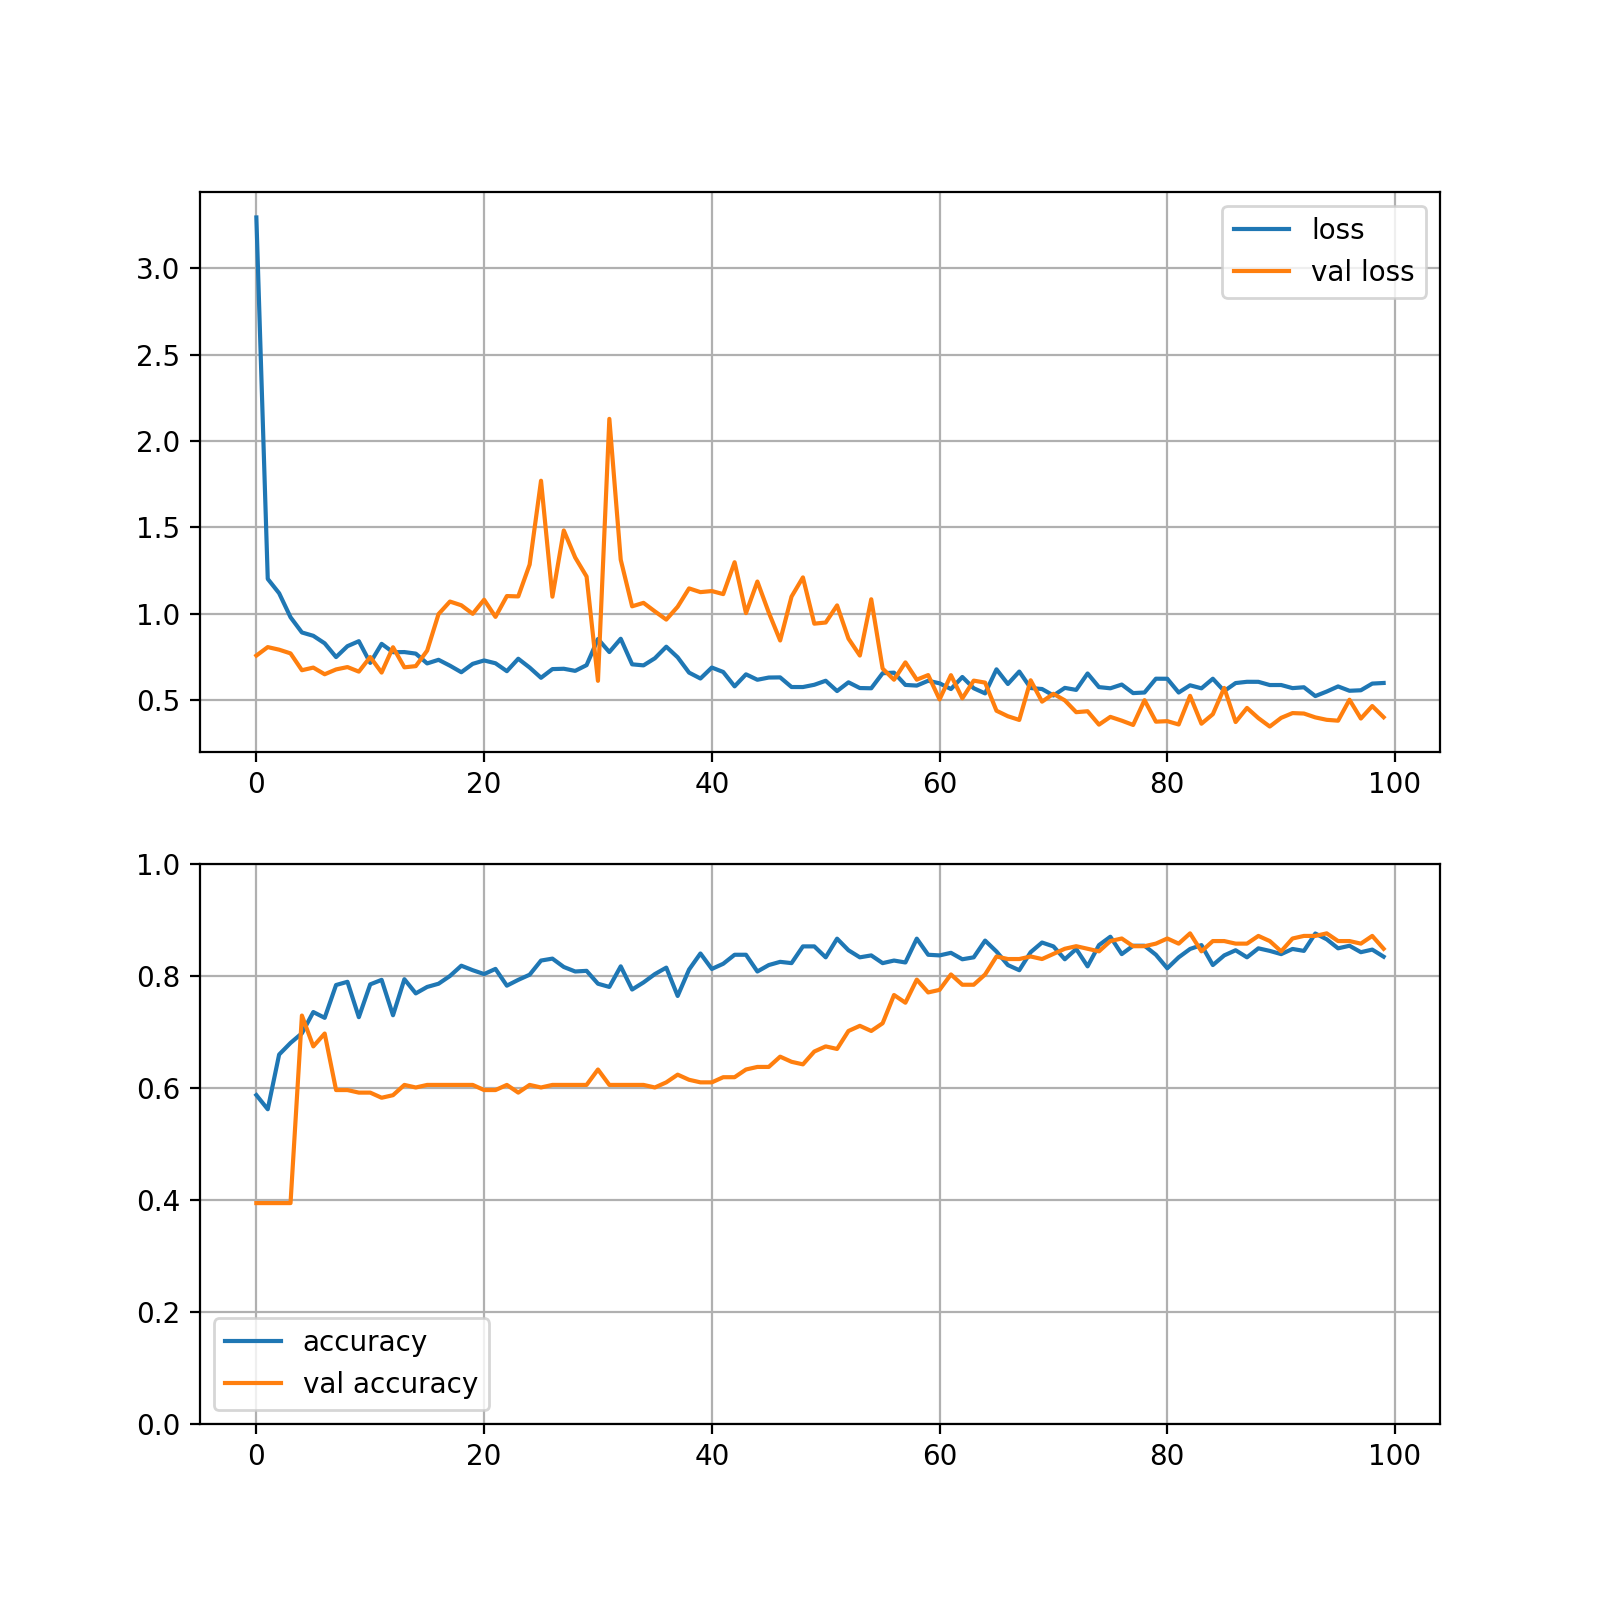

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

axes[0].plot(history.history['loss'], label='loss')
axes[0].plot(history.history['val_loss'], label='val loss')
axes[0].grid()
axes[0].legend()

axes[1].plot(history.history['accuracy'], label='accuracy')
axes[1].plot(history.history['val_accuracy'], label='val accuracy')
axes[1].grid()
axes[1].legend()
axes[1].set_ylim(0,1)

fig.savefig('train_performamce.pdf')

In [16]:
res = model.predict(X_test) 

threashold = 0.5
y_pred = decode(res, threshold=threashold)
y_true = decode(y_test, threshold=threashold)

In [17]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       132
           1       0.84      0.77      0.80        86

    accuracy                           0.85       218
   macro avg       0.85      0.83      0.84       218
weighted avg       0.85      0.85      0.85       218



In [18]:
cm = confusion_matrix(y_true, y_pred)

print(cm)
print()
print(cm/cm.sum(axis=1)[:, np.newaxis])

[[119  13]
 [ 20  66]]

[[0.90151515 0.09848485]
 [0.23255814 0.76744186]]


<IPython.core.display.Javascript object>


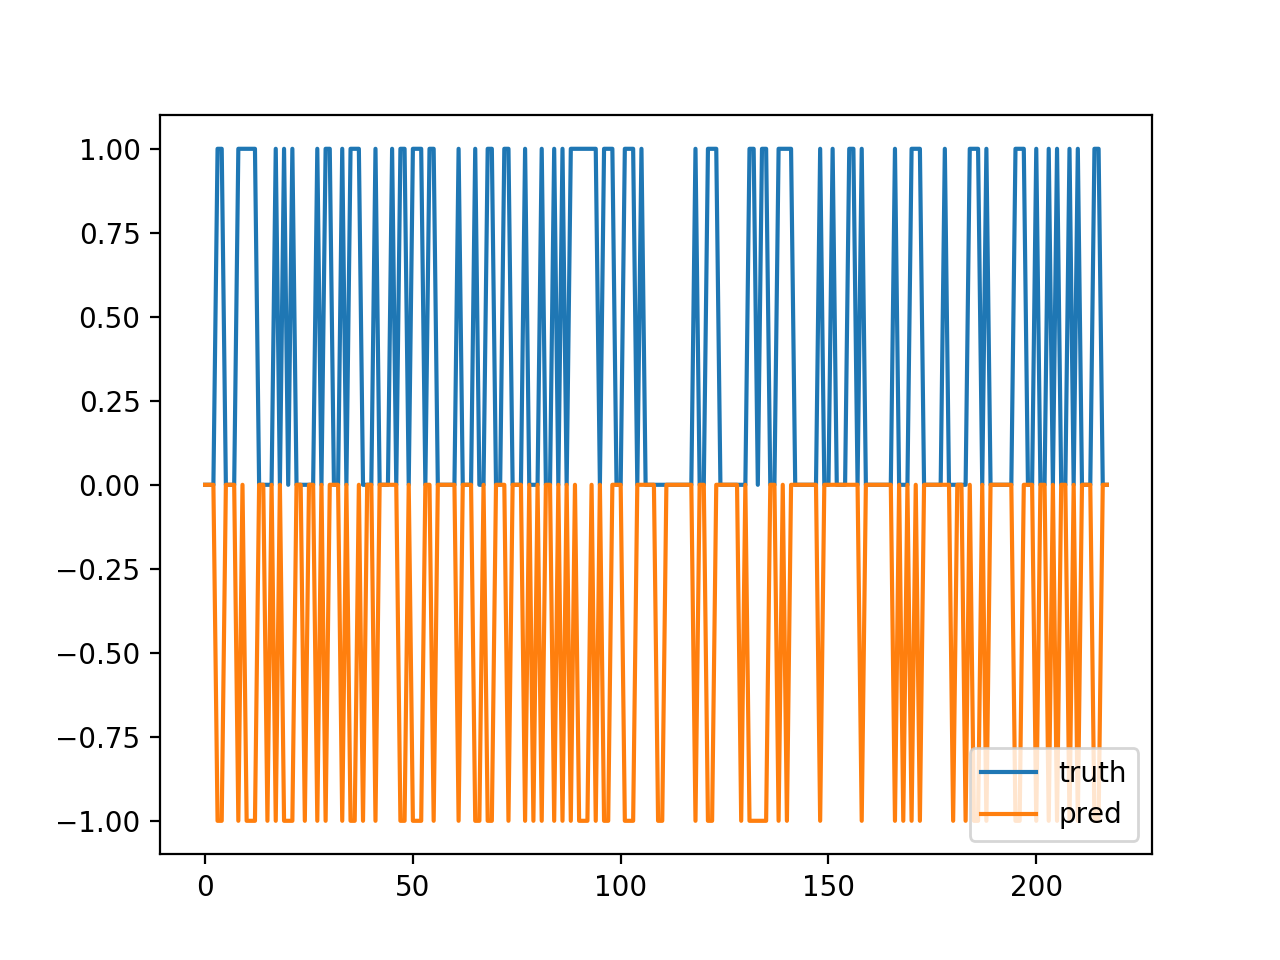

In [20]:
plt.figure()
plt.plot(y_true, label='truth')
plt.plot(-1*y_pred, label='pred')
plt.legend()
plt.show()

In [ ]:
len(y_pred), y_pred.sum()